# Variable respuesta para clasificar las casas en Economicas, Intermedias o Caras

Tercil 1 (33.33%): $139,685
Tercil 2 (66.67%): $190,000

Distribución de categorías:
PriceCategory
Económica     487
Intermedia    490
Cara          483
Name: count, dtype: int64
Porcentajes: PriceCategory
Económica     33.356164
Intermedia    33.561644
Cara          33.082192
Name: count, dtype: float64


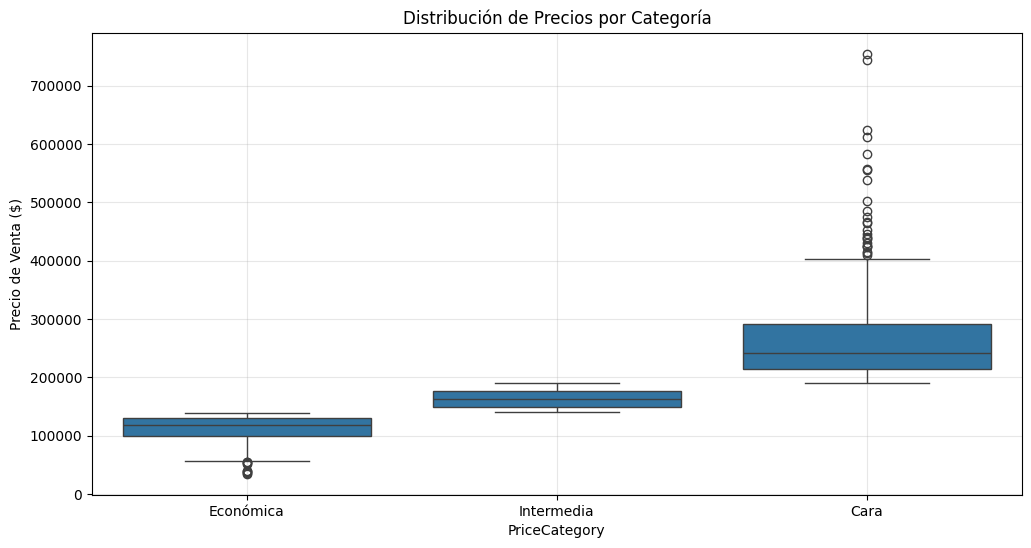

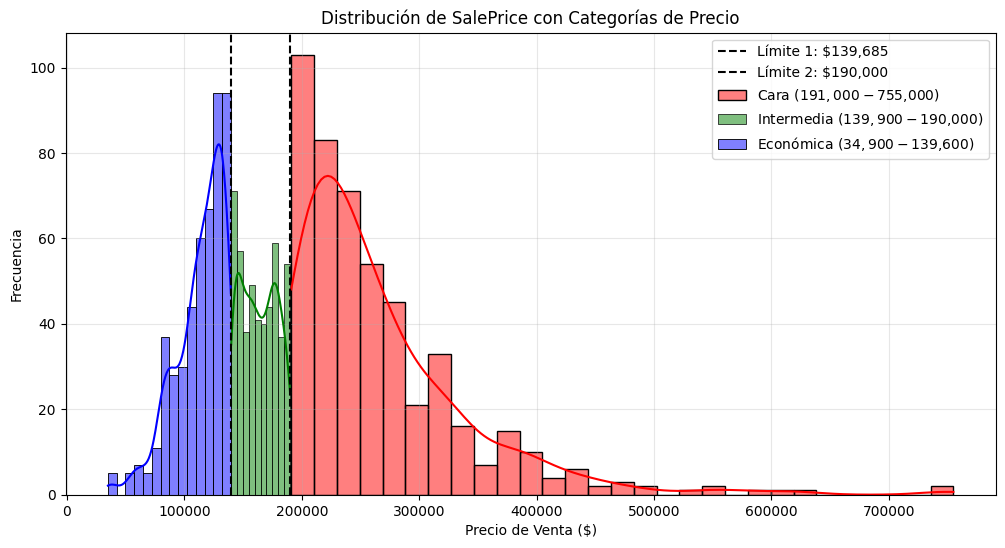

In [4]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
df = pd.read_csv('../../train.csv')

# Calcular los tercilos (dividir los datos en tres partes iguales)
tercil_1 = np.percentile(df['SalePrice'], 33.33)
tercil_2 = np.percentile(df['SalePrice'], 66.67)

print(f"Tercil 1 (33.33%): ${int(tercil_1):,}")
print(f"Tercil 2 (66.67%): ${int(tercil_2):,}")

# Crear la variable de clasificación
df['PriceCategory'] = pd.cut(
    df['SalePrice'],
    bins=[0, tercil_1, tercil_2, float('inf')],
    labels=['Económica', 'Intermedia', 'Cara'],
    include_lowest=True
)

# Verificar la distribución de las categorías
category_counts = df['PriceCategory'].value_counts().sort_index()
print("\nDistribución de categorías:")
print(category_counts)
print(f"Porcentajes: {category_counts / len(df) * 100}")

# Visualizar la distribución de precios por categoría
plt.figure(figsize=(12, 6))
sns.boxplot(x='PriceCategory', y='SalePrice', data=df)
plt.title('Distribución de Precios por Categoría')
plt.ylabel('Precio de Venta ($)')
plt.grid(True, alpha=0.3)
plt.show()

# Crear un histograma con las categorías coloreadas
plt.figure(figsize=(12, 6))
colors = {'Económica': 'blue', 'Intermedia': 'green', 'Cara': 'red'}

for category in df['PriceCategory'].unique():
    subset = df[df['PriceCategory'] == category]
    sns.histplot(subset['SalePrice'], kde=True, 
                 label=f"{category} (${int(subset['SalePrice'].min()):,} - ${int(subset['SalePrice'].max()):,})",
                 alpha=0.5, color=colors[category])

plt.axvline(tercil_1, color='black', linestyle='--', label=f'Límite 1: ${int(tercil_1):,}')
plt.axvline(tercil_2, color='black', linestyle='--', label=f'Límite 2: ${int(tercil_2):,}')
plt.title('Distribución de SalePrice con Categorías de Precio')
plt.xlabel('Precio de Venta ($)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Árbol de Clasificación

Tercil 1 (33.33%): $139,685
Tercil 2 (66.67%): $190,000

Precisión del modelo: 0.7352

Matriz de confusión:
[[125   4  16]
 [  6  99  41]
 [ 27  22  98]]

Informe de clasificación:
              precision    recall  f1-score   support

        Cara       0.79      0.86      0.83       145
   Económica       0.79      0.68      0.73       146
  Intermedia       0.63      0.67      0.65       147

    accuracy                           0.74       438
   macro avg       0.74      0.74      0.73       438
weighted avg       0.74      0.74      0.73       438


Importancia de las características:
        Feature  Importance
0   OverallQual    0.438970
1     GrLivArea    0.244199
3     YearBuilt    0.144381
4   TotalBsmtSF    0.140773
8   KitchenQual    0.016705
9      BsmtQual    0.014972
5      FullBath    0.000000
2    GarageCars    0.000000
7     ExterQual    0.000000
6  Neighborhood    0.000000

No se pudo generar la visualización con graphviz. Usa el archivo 'decision_tree.png'.
Reglas

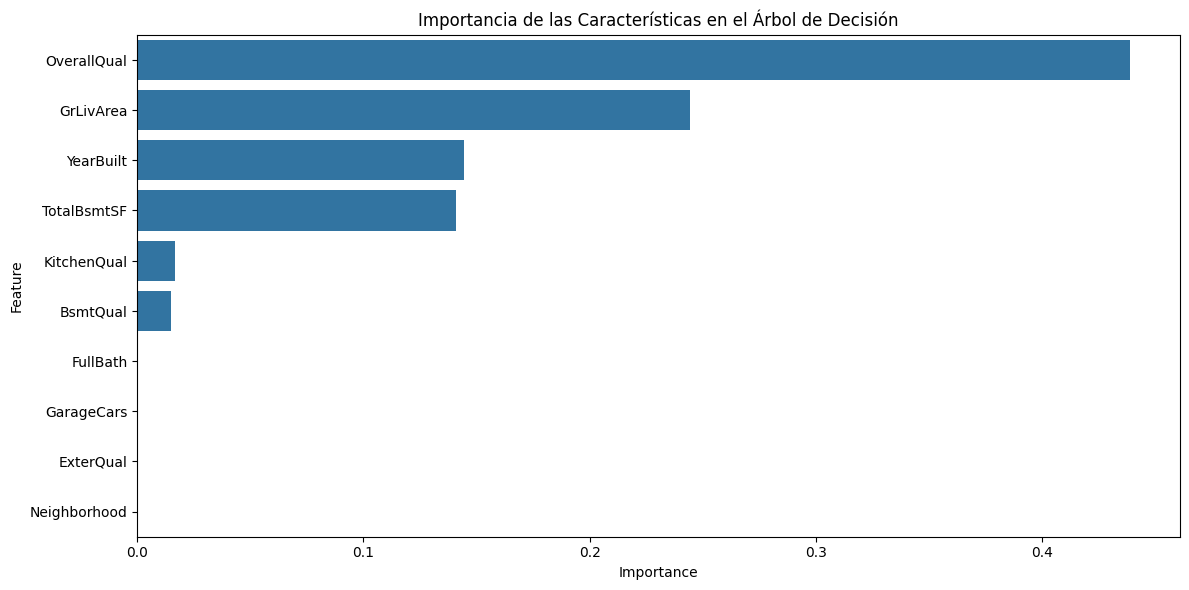

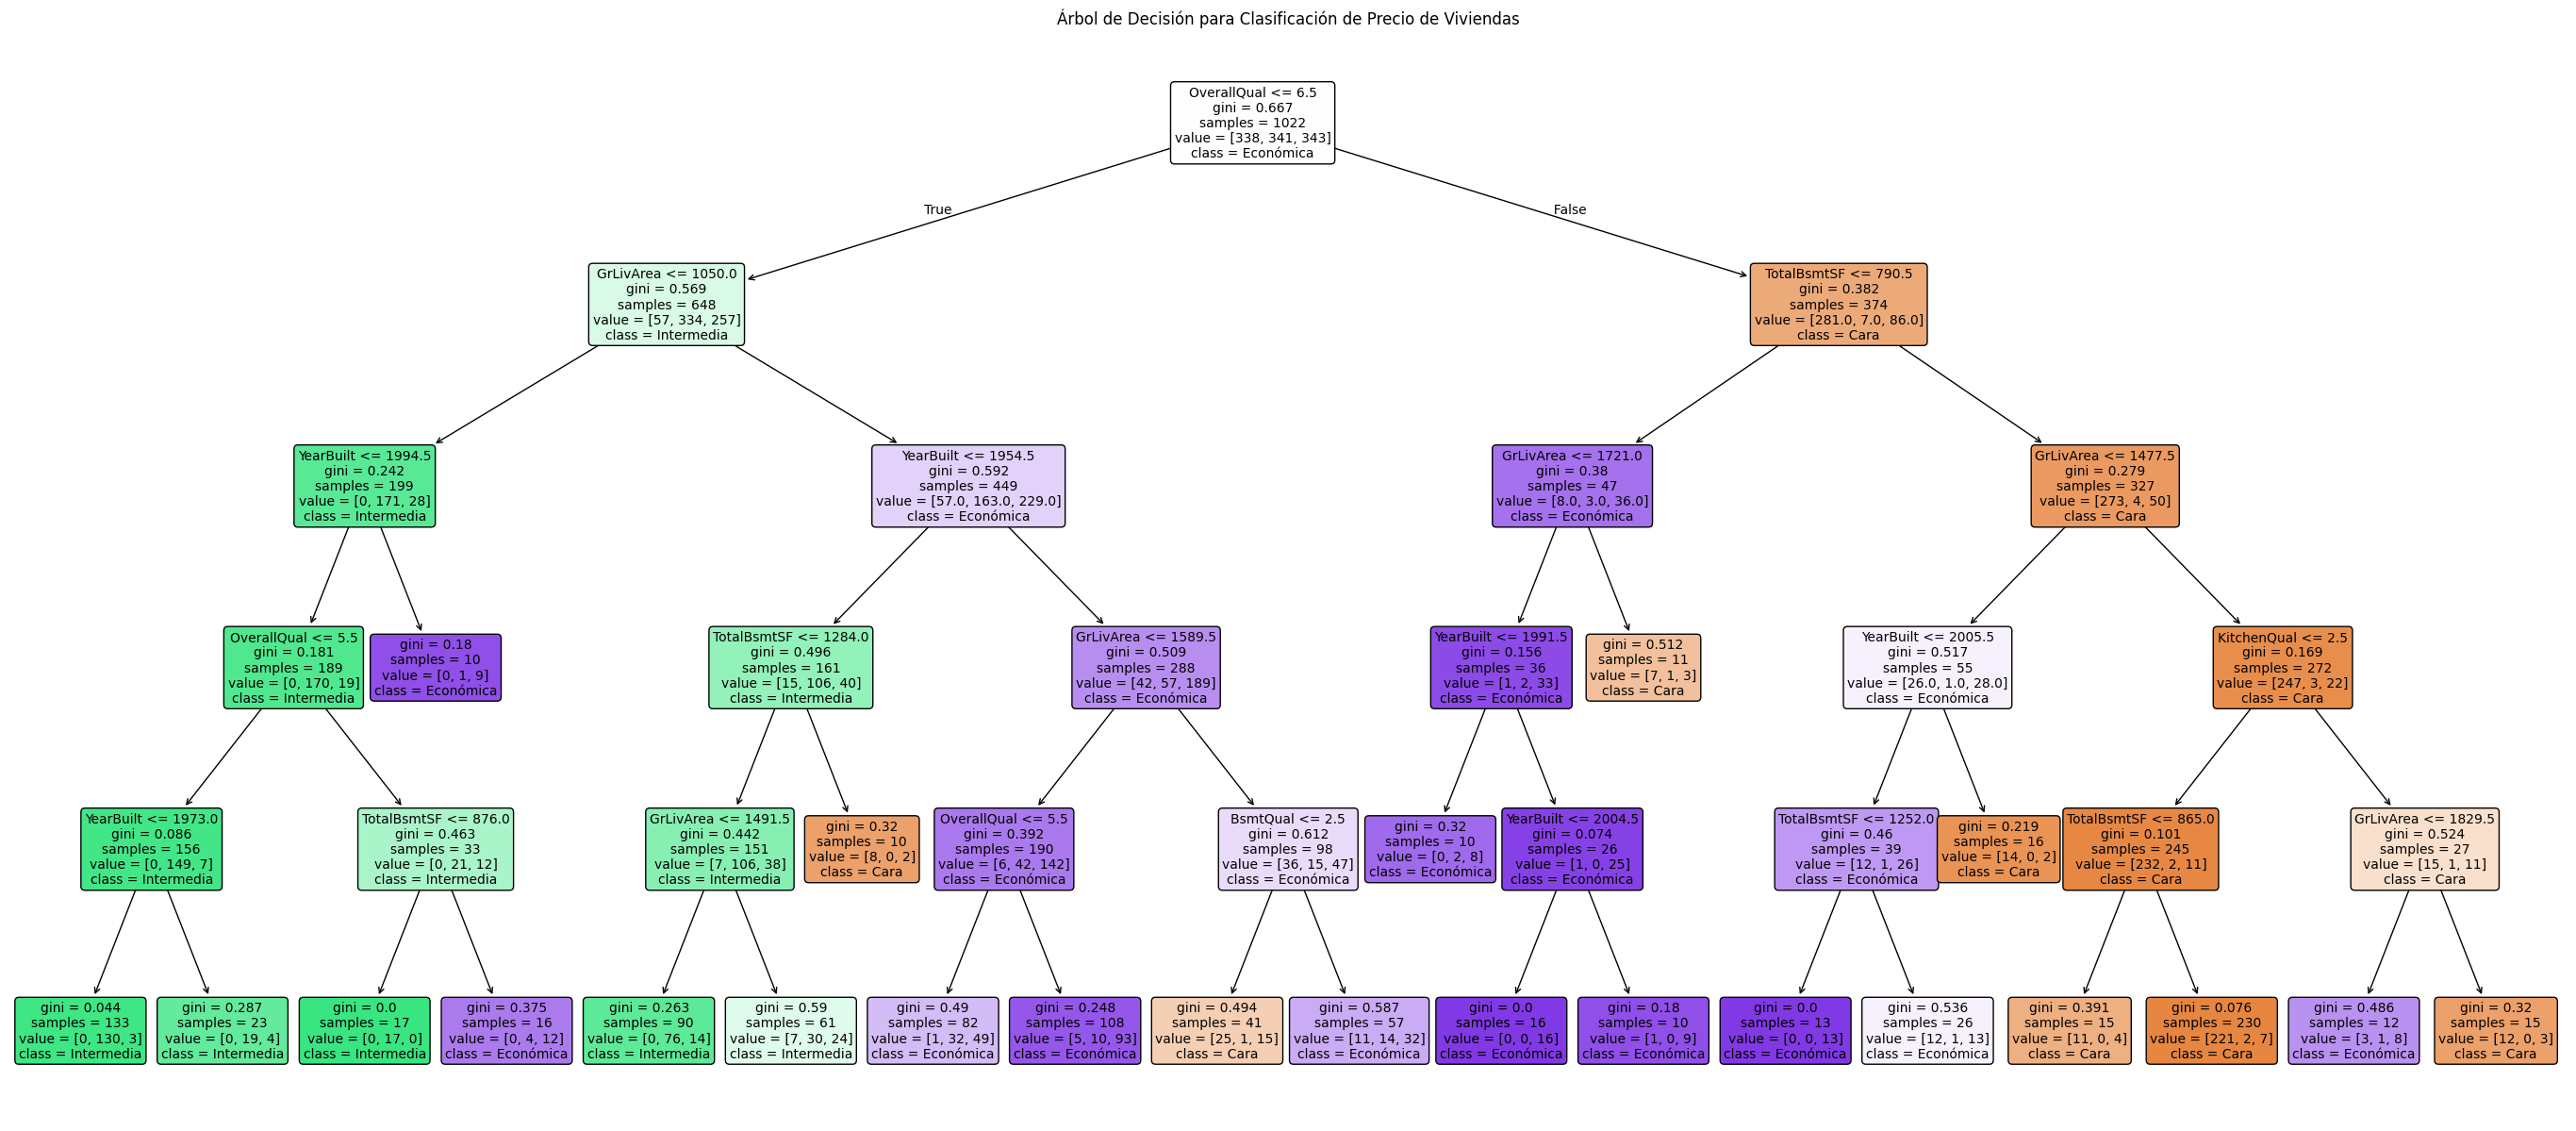

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import graphviz 


print(f"Tercil 1 (33.33%): ${int(tercil_1):,}")
print(f"Tercil 2 (66.67%): ${int(tercil_2):,}")


# 2. Seleccionar las características para el modelo
# Basado en nuestro análisis previo, seleccionamos las características más importantes
selected_features = [
    'OverallQual',    # Calidad general
    'GrLivArea',      # Área habitable
    'GarageCars',     # Capacidad del garaje
    'YearBuilt',      # Año de construcción
    'TotalBsmtSF',    # Superficie total del sótano
    'FullBath',       # Baños completos
    'Neighborhood',   # Vecindario (categórica)
    'ExterQual',      # Calidad del exterior (categórica)
    'KitchenQual',    # Calidad de la cocina (categórica)
    'BsmtQual'        # Calidad del sótano (categórica)
]

# 3. Preparar las características para el modelo
X = df[selected_features].copy()
y = df['PriceCategory']

# Manejar valores faltantes en características numéricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='median')
X[numeric_features] = imputer.fit_transform(X[numeric_features])

# Manejar valores faltantes en características categóricas
categorical_features = X.select_dtypes(include=['object']).columns
X[categorical_features] = X[categorical_features].fillna('None')

# Codificar variables categóricas
encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])
    encoders[feature] = le

# 4. Dividir en conjuntos de entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 5. Crear y entrenar el modelo
# Configuramos el árbol con una profundidad limitada para evitar sobreajuste
dt_classifier = DecisionTreeClassifier(
    max_depth=5,             # Profundidad máxima del árbol
    min_samples_split=20,    # Mínimo de muestras para dividir un nodo
    min_samples_leaf=10,     # Mínimo de muestras en un nodo hoja
    random_state=42
)

# Entrenar el modelo
dt_classifier.fit(X_train, y_train)

# 6. Evaluar el modelo
y_pred = dt_classifier.predict(X_test)

# Precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisión del modelo: {accuracy:.4f}")

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusión:")
print(conf_matrix)

# Informe de clasificación
class_report = classification_report(y_test, y_pred)
print("\nInforme de clasificación:")
print(class_report)

# 7. Visualizar la importancia de las características
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_classifier.feature_importances_
})

feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("\nImportancia de las características:")
print(feature_importance)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Importancia de las Características en el Árbol de Decisión')
plt.tight_layout()

# 8. Visualizar el árbol de decisión
plt.figure(figsize=(35, 15))
plot_tree(
    dt_classifier, 
    feature_names=list(X.columns),
    class_names=list(y.unique()),
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title('Árbol de Decisión para Clasificación de Precio de Viviendas')

# Versión más legible del árbol usando graphviz (si está instalado)
try:
    dot_data = export_graphviz(
        dt_classifier,
        out_file=None,
        feature_names=list(X.columns),
        class_names=list(y.unique()),
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    graph.render("decision_tree_graphviz")
    print("\nÁrbol de decisión exportado a 'decision_tree_graphviz.pdf'")
except:
    print("\nNo se pudo generar la visualización con graphviz. Usa el archivo 'decision_tree.png'.")

# 9. Extraer reglas del árbol para interpretación manual
def get_tree_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!"
        for i in tree_.feature
    ]
    
    print("Reglas del árbol de decisión:")
    
    def recurse(node, depth, parent=None, condition=None):
        indent = "  " * depth
        if tree_.feature[node] != -2:  # Internal node
            name = feature_name[node]
            threshold = tree_.threshold[node]
            
            if parent is not None:
                print(f"{indent}IF {condition} THEN")
            
            # Left child (<=)
            recurse(
                tree_.children_left[node], 
                depth + 1, 
                node,
                f"{name} <= {threshold:.2f}"
            )
            
            # Right child (>)
            recurse(
                tree_.children_right[node], 
                depth + 1, 
                node,
                f"{name} > {threshold:.2f}"
            )
        else:  # Leaf node
            class_probabilities = tree_.value[node][0]
            class_index = np.argmax(class_probabilities)
            class_name = class_names[class_index]
            n_samples = tree_.n_node_samples[node]
            prob = class_probabilities[class_index] / np.sum(class_probabilities)
            
            print(f"{indent}IF {condition} THEN {class_name} ({n_samples} samples, {prob:.2%} probability)")
    
    recurse(0, 1)  # Start with the root node (index 0) and depth 1

# Extraer reglas del árbol
get_tree_rules(dt_classifier, list(X.columns), list(y.unique()))

# 10. Función para clasificar nuevas propiedades
def classify_house_price(house_features, model, encoders, imputer):
    """
    Clasifica una nueva propiedad usando el modelo entrenado.
    
    Args:
        house_features: Diccionario con las características de la casa
        model: Modelo entrenado
        encoders: Diccionario de codificadores para variables categóricas
        imputer: Imputador para valores faltantes
        
    Returns:
        Categoría de precio predicha
    """
    # Crear un DataFrame con las características
    house_df = pd.DataFrame([house_features])
    
    # Completar valores faltantes en características numéricas
    numeric_cols = house_df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_cols) > 0:
        house_df[numeric_cols] = imputer.transform(house_df[numeric_cols])
    
    # Codificar variables categóricas
    for col, encoder in encoders.items():
        if col in house_df.columns:
            # Manejar valores nuevos que no estaban en el conjunto de entrenamiento
            try:
                house_df[col] = encoder.transform(house_df[col])
            except:
                # Usar el valor más común si es un valor desconocido
                house_df[col] = 0
    
    # Realizar la predicción
    prediction = model.predict(house_df)[0]
    
    return prediction

# Ejemplo de una nueva propiedad para clasificar
new_house = {
    'OverallQual': 7,
    'GrLivArea': 1800,
    'GarageCars': 2,
    'YearBuilt': 2000,
    'TotalBsmtSF': 1200,
    'FullBath': 2,
    'Neighborhood': 'NridgHt',
    'ExterQual': 'Gd',
    'KitchenQual': 'Gd',
    'BsmtQual': 'Gd'
}

predicted_category = classify_house_price(new_house, dt_classifier, encoders, imputer)
print(f"\nCategoría predicha para la nueva propiedad: {predicted_category}")

# Uso de conjunto de prueba para determinar eficiencia 